# Land use/ Land cover segmentation notebook

In [2]:
#importing libraries 
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import  onnx
import onnxruntime as ort

import rasterio as rio
from rasterio.merge import merge
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import time
import shutil

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Device and torch version

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cpu


### Dataset

In [4]:
dataset_folder = './data/LULC_data'
train_folder = './data/LULC_data/training'
test_folder = './data/LULC_data/testing'

test_ratio = 0.2 # train-test split ratio

# Create the training and testing folders
os.makedirs(train_folder+'/images/images', exist_ok=True)
os.makedirs(train_folder+'/masks/masks', exist_ok=True)

os.makedirs(test_folder+'/images/images', exist_ok=True)
os.makedirs(test_folder+'/masks/masks', exist_ok=True)

In [6]:
# Get the list of image and mask filenames
image_folder = os.path.join(dataset_folder, 'images')
mask_folder = os.path.join(dataset_folder, 'masks')

image_filenames = os.listdir(image_folder)
mask_filenames = os.listdir(mask_folder)
print(f'Total images: {len(image_filenames)}')

# Sort the filenames to ensure consistent splitting
image_filenames.sort()
mask_filenames.sort()

# Check if the number of images and masks are the same
if len(image_filenames) != len(mask_filenames):
    print("Number of images and masks do not match!")
    exit(1)


Total images: 15524
Number of images and masks do not match!


In [5]:
data = list(zip(image_filenames, mask_filenames))  # Create a list of tuples containing the image and mask filenames

random.seed(42)  # for reproducibility
random.shuffle(data)  # Randomly shuffle the data

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=test_ratio)

# Move the training data to the train_folder
for image_filename, mask_filename in train_data:
    shutil.move(os.path.join(image_folder, image_filename), train_folder+'/images')
    shutil.move(os.path.join(mask_folder, mask_filename), train_folder+'/masks')

# Move the testing data to the test_folder
for image_filename, mask_filename in test_data:
    shutil.move(os.path.join(image_folder, image_filename), test_folder+'/images')
    shutil.move(os.path.join(mask_folder, mask_filename), test_folder+'/masks')


In [3]:
# Transformation for normalizing and converting the image to tensor
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),

])

In [4]:
class Segmentation_dataset(Dataset):
    def __init__(self, folder_path, augment=True):
        super(Segmentation_dataset, self).__init__()
        self.img_files = glob(os.path.join(folder_path, 'images', '*.jpg'))
        self.mask_files = []
        self.augment = augment

        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path, 'masks', os.path.basename(img_path[:-3]+'png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.augment:
            image, label = self.apply_augmentation(image, label)

        image, label = image_transform(image), torch.squeeze((target_transform(label))*255).long()
        return image, label

    def __len__(self):
        return len(self.img_files)

    def apply_augmentation(self, image, label):
        # Randomly apply data augmentation techniques to the image and mask

        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            image__=transforms.ToPILImage()(image)
            label__=transforms.ToPILImage()(label)
            image = transforms.functional.rotate(image__, angle)
            label = transforms.functional.rotate(label__, angle)

        if random.random() > 0.5:
            image_=np.array(image)
            label_=np.array(label)
            image = cv2.flip(image_, 1)
            label = cv2.flip(label_, 1)

        return np.array(image), np.array(label)



In [5]:
train_dataset = Segmentation_dataset('../data/LULC_data/training', augment=True)
test_dataset = Segmentation_dataset('../data/LULC_data/testing', augment=False)

In [6]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])



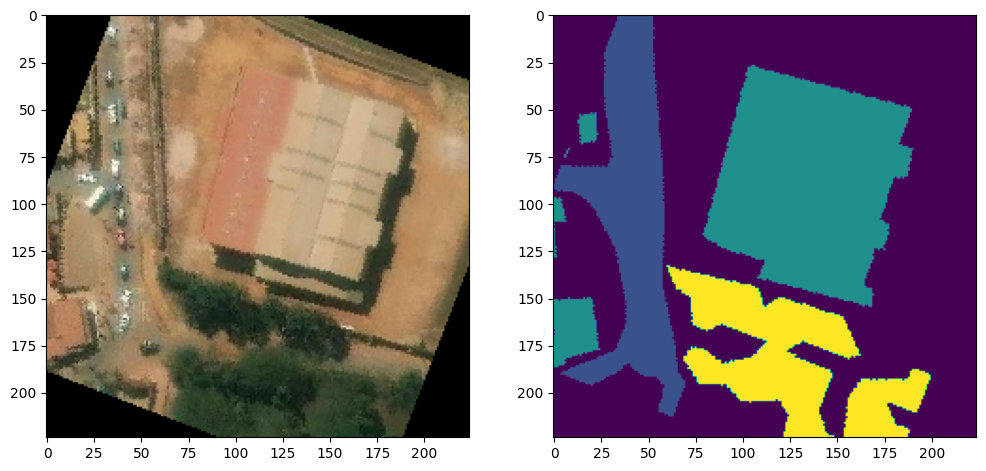

In [7]:
for data in train_dataset:
    x, y = data
    print(f'Image shape: {x.shape}\nMask shape: {y.shape}')
    print()
    fig, ax = plt.subplots(1,2, figsize=(12,10))
    ax[0].imshow(inv_normalize(x.cpu()).permute(1, 2, 0))
    ax[1].imshow(y.cpu())
    break

### Dataloader

In [8]:
train_dloader    = DataLoader(
                        train_dataset,
                        batch_size=32,
                        shuffle=True
                        )
val_dloader      = DataLoader(
                        test_dataset,
                        batch_size=8,
                        shuffle=False
                        )

### Helper functions

In [5]:
def merge_files(files):

    rasters = [ rio.open(f) for f in files ]
    mosaic, trans = merge(rasters)

    # Get metadata from the first raster
    meta = rasters[0].meta.copy()

    # Update metadata with mosaic shape and transform
    meta.update({
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': trans
    })

    # Close all opened rasters
    for raster in rasters:
        raster.close()

    return mosaic, meta


In [6]:
def save_merged(mosaic, meta, out_path):

    with rio.open(out_path, 'w', **meta) as dst:
        dst.write(mosaic)


In [7]:
def create_image_from_patches(patches_path, out_path):

    patches_names = glob(os.path.join(patches_path,"*.tif"))
    mosaic, meta = merge_files(patches_names)
    save_merged(mosaic=mosaic, meta=meta, out_path=out_path)

In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Model total parameters: {sum(params):>6}')

In [9]:
def upconv(ch_in, ch_out, kernel_size=(3, 3),stride=1, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels=ch_in, out_channels=ch_out, kernel_size=kernel_size,
                               stride=stride, padding=padding),
      nn.ReLU(inplace=True),
  )


In [10]:
def convert_2_onnx(path, model, batch_size=1):
  """
  Convert pytorch model to onnx
  """
  dummy_input = torch.randn(batch_size, 3, 224, 224, requires_grad=True).to(device)
  model.eval() # set the model to inference mode

  # Export the model
  torch.onnx.export(model,
        dummy_input,
        path,
        input_names = ['input'],
        output_names = ['output'],
        dynamic_axes = {'input':{0:'batch_size'}, 
                        'output':{0:'batch_size'}})

#### Model architecture

In [11]:
class Unet_mobilenet(nn.Module):

    def __init__(self, n_class,
                 pretrained=True
                 ):
        super().__init__()

        self.backbone = models.mobilenet_v2(pretrained=pretrained)

        self.layer0 = nn.Sequential(self.backbone.features[0])
        self.layer1 = self.backbone.features[1:3]
        self.layer2 = self.backbone.features[3:7]
        self.layer3 = self.backbone.features[7:14]
        self.layer4 = self.backbone.features[14:]

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up3 = upconv(1376, 960, 3, 1) 
        self.conv_up2 = upconv(992, 576, 3, 1) 
        self.conv_up1 = upconv(600, 384, 3, 1) 
        self.conv_up0 = upconv(416, 192 , 3, 1) 

        self.conv_original_size0 = upconv(3, 32, 3, 1)
        self.conv_original_size1 = upconv(32, 96, 3, 1)
        self.conv_original_size2 = upconv(288, 96, 3, 1) 

        self.final_conv = nn.Conv2d(96, n_class, 1)


    def forward(self, input):
      x_original = self.conv_original_size0(input)
      x_original = self.conv_original_size1(x_original)

      layer0 = self.layer0(input)
      layer1 = self.layer1(layer0)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)
      layer4 = self.layer4(layer3)

      x = self.upsample(layer4)
      x = torch.cat([x, layer3], dim=1)
      x = self.conv_up3(x)

      x = self.upsample(x)
      x = torch.cat([x, layer2], dim=1)
      x = self.conv_up2(x)

      x = self.upsample(x)
      x = torch.cat([x, layer1], dim=1)
      x = self.conv_up1(x)

      x = self.upsample(x)
      x = torch.cat([x, layer0], dim=1)
      x = self.conv_up0(x)

      x = self.upsample(x)
      x = torch.cat([x, x_original], dim=1)
      x = self.conv_original_size2(x)

      out = self.final_conv(x)

      return out


In [12]:
class Unet_squeezenet(nn.Module):

    def __init__(self, n_class,
                 pretrained=True
                 ):
        super().__init__()

        self.backbone = models.squeezenet1_1(pretrained=pretrained)

        self.layer0 = nn.Sequential(self.backbone.features[:4])
        self.layer1 = self.backbone.features[4:7]
        self.layer2 = self.backbone.features[7:9]
        self.layer3 = self.backbone.features[9:11]
        self.layer4 = self.backbone.features[11:]

        self.upsample1 = nn.Upsample(size=27, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(size=55, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(size=224, mode='bilinear', align_corners=True)
        self.conv_up3 = upconv(896, 512, 3, 1) 
        self.conv_up2 = upconv(768, 384, 3, 1) 
        self.conv_up1 = upconv(640, 256, 3, 1) 
        self.conv_up0 = upconv(384, 128 , 3, 1) 

        self.conv_original_size0 = upconv(3, 64, 3, 1)
        self.conv_original_size1 = upconv(64, 64, 3, 1)
        self.conv_original_size2 = upconv(192, 64, 3, 1) 

        self.final_conv = nn.Conv2d(64, n_class, 1)


    def forward(self, input):
      x_original = self.conv_original_size0(input)
      x_original = self.conv_original_size1(x_original)

      layer0 = self.layer0(input)
      layer1 = self.layer1(layer0)
      layer2 = self.layer2(layer1)
      layer3 = self.layer3(layer2)
      layer4 = self.layer4(layer3)

      x = torch.cat([layer4, layer3], dim=1)
      x = self.conv_up3(x)

      x = torch.cat([x, layer2], dim=1)
      x = self.conv_up2(x)

      x = self.upsample1(x)
      x = torch.cat([x, layer1], dim=1)
      x = self.conv_up1(x)

      x = self.upsample2(x)
      x = torch.cat([x, layer0], dim=1)
      x = self.conv_up0(x)

      x = self.upsample3(x)
      x = torch.cat([x, x_original], dim=1)
      x = self.conv_original_size2(x)

      out = self.final_conv(x)

      return out


### Loss function

In [13]:
n_class=7

In [14]:
ce = nn.CrossEntropyLoss()

def cEntropy_Loss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    
    return ce_loss, acc

### Models Training and evaluation

In [26]:
mobilenet_model = Unet_mobilenet(n_class=n_class
                ).to(device)

mobilenet_optimizer = torch.optim.Adam(mobilenet_model.parameters(), lr=0.0001)

# Total number of parameters in the model
count_parameters(mobilenet_model)

Model total parameters: 23608847


In [27]:
squeezenet_model = Unet_squeezenet(n_class=n_class
                ).to(device)

squeezenet_optimizer = torch.optim.Adam(squeezenet_model.parameters(), lr=0.0001)

# Total number of parameters in the model
count_parameters(squeezenet_model)

Model total parameters: 10086511


In [28]:
deeplab_mobl_model = models.segmentation.deeplabv3_mobilenet_v3_large(num_classes=n_class, aux_loss=True).to(device)

deeplab_mobl_optimizer = torch.optim.Adam(deeplab_mobl_model.parameters(), lr=0.0001)

# Total number of parameters in the model
count_parameters(deeplab_mobl_model)

Model total parameters: 11025576


In [29]:
lraspp_mobl_model = models.segmentation.lraspp_mobilenet_v3_large(num_classes=n_class).to(device)

lraspp_mobl_optimizer = torch.optim.Adam(lraspp_mobl_model.parameters(), lr=0.0001)

# Total number of parameters in the model
count_parameters(lraspp_mobl_model)

Model total parameters: 3219158


In [30]:
MODELS=[mobilenet_model, squeezenet_model, deeplab_mobl_model, lraspp_mobl_model]
Optimizers=[mobilenet_optimizer, squeezenet_optimizer, deeplab_mobl_optimizer, lraspp_mobl_optimizer]
model_names = ['Umobilenet_v2_2', 'Usqueezenet_v2_2', 'deeplab_moblnet_v2_2', 'lraspp_mobilenet_v2_2']

In [31]:
# Training and validation losses and accuracies
train_loss_avg = {name:[] for name in model_names}
train_acc_avg = {name:[] for name in model_names}

val_acc_avg = {name:[] for name in model_names}
val_loss_avg = {name:[] for name in model_names}

In [32]:
i=0
for model, optimizer in zip(MODELS, Optimizers):
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience = 10
    counter = 0  # Counter for epochs without improvement
    print(f'\n******************************\n   {model_names[i]}   \n******************************\n')
    for epoch in range(100):
        print(f"       Epoch: {epoch}   \n   ******************   ")

        # Train
        model.train()
        train_losses = []
        train_accs = []

        for bx, (_images, masks_) in tqdm(enumerate(train_dloader), total=len(train_dloader)):
            ims, ce_masks = _images.to(device), masks_.to(device)

            _masks = model(ims)
            optimizer.zero_grad()
            if model_names[i] in ['deeplab_moblnet_v2_2', 'lraspp_mobilenet_v2_2']:
                _masks = _masks['out']
            loss, acc = cEntropy_Loss(_masks, ce_masks)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_accs.append(acc.item())

        train_loss_avg[model_names[i]].append(np.mean(train_losses))
        train_acc_avg[model_names[i]].append(np.mean(train_accs))

        # Validate
        model.eval()
        val_losses = []
        val_accs = []

        with torch.no_grad():
            for bx, (_images, masks_) in tqdm(enumerate(val_dloader), total=len(val_dloader)):
                val_ims, val_masks = _images.to(device), masks_.to(device)

                pred_masks = model(val_ims)
                if model_names[i] in ['deeplab_moblnet_v2_2', 'lraspp_mobilenet_v2_2']:
                    pred_masks = pred_masks['out']
                loss, acc = cEntropy_Loss(pred_masks, val_masks)
                val_losses.append(loss.item())
                val_accs.append(acc.item())

        if np.mean(val_losses) < best_val_loss:
            best_val_loss = np.mean(val_losses)
            counter = 0
            torch.save(model.state_dict(), f'../models/{model_names[i]}.pth')  # Save the best model
        else:
            counter += 1

        # Check if training should be stopped
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

        val_loss_avg[model_names[i]].append(np.mean(val_losses))
        val_acc_avg[model_names[i]].append(np.mean(val_accs))

        print(f"Train loss: {train_loss_avg[model_names[i]][epoch]:.4f}\tTrain acc: {train_acc_avg[model_names[i]][epoch]:.4f}\tVal loss: {val_loss_avg[model_names[i]][epoch]:.4f}\tVal acc: {val_acc_avg[model_names[i]][epoch]:.4f}\n")

    i+=1


******************************
   Umobilenet_v2_2   
******************************

       Epoch: 0   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.30it/s]


Train loss: 0.4217	Train acc: 0.8402	Val loss: 0.2040	Val acc: 0.9162

       Epoch: 1   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.22it/s]


Train loss: 0.2060	Train acc: 0.9185	Val loss: 0.1659	Val acc: 0.9343

       Epoch: 2   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.32it/s]


Train loss: 0.1689	Train acc: 0.9334	Val loss: 0.1406	Val acc: 0.9448

       Epoch: 3   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.16it/s]


Train loss: 0.1469	Train acc: 0.9411	Val loss: 0.1313	Val acc: 0.9486

       Epoch: 4   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.19it/s]


Train loss: 0.1372	Train acc: 0.9459	Val loss: 0.1463	Val acc: 0.9396

       Epoch: 5   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.21it/s]


Train loss: 0.1367	Train acc: 0.9451	Val loss: 0.1243	Val acc: 0.9496

       Epoch: 6   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.38it/s]


Train loss: 0.1267	Train acc: 0.9497	Val loss: 0.1395	Val acc: 0.9466

       Epoch: 7   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.49it/s]


Train loss: 0.1210	Train acc: 0.9511	Val loss: 0.1205	Val acc: 0.9514

       Epoch: 8   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.46it/s]


Train loss: 0.1117	Train acc: 0.9550	Val loss: 0.1296	Val acc: 0.9489

       Epoch: 9   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.25it/s]


Train loss: 0.1108	Train acc: 0.9556	Val loss: 0.1190	Val acc: 0.9519

       Epoch: 10   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.37it/s]


Train loss: 0.1065	Train acc: 0.9573	Val loss: 0.1256	Val acc: 0.9522

       Epoch: 11   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.26it/s]


Train loss: 0.1168	Train acc: 0.9552	Val loss: 0.1193	Val acc: 0.9522

       Epoch: 12   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.37it/s]


Train loss: 0.1071	Train acc: 0.9573	Val loss: 0.1310	Val acc: 0.9498

       Epoch: 13   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.35it/s]


Train loss: 0.1020	Train acc: 0.9585	Val loss: 0.1326	Val acc: 0.9505

       Epoch: 14   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.38it/s]


Train loss: 0.1180	Train acc: 0.9550	Val loss: 0.1199	Val acc: 0.9524

       Epoch: 15   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.06it/s]


Train loss: 0.0977	Train acc: 0.9608	Val loss: 0.1517	Val acc: 0.9485

       Epoch: 16   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.36it/s]


Train loss: 0.0958	Train acc: 0.9619	Val loss: 0.1168	Val acc: 0.9548

       Epoch: 17   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.34it/s]


Train loss: 0.0903	Train acc: 0.9636	Val loss: 0.1144	Val acc: 0.9548

       Epoch: 18   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.61it/s]


Train loss: 0.0866	Train acc: 0.9649	Val loss: 0.1243	Val acc: 0.9515

       Epoch: 19   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.21it/s]


Train loss: 0.0839	Train acc: 0.9654	Val loss: 0.1167	Val acc: 0.9549

       Epoch: 20   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.43it/s]


Train loss: 0.0833	Train acc: 0.9654	Val loss: 0.1230	Val acc: 0.9532

       Epoch: 21   
   ******************   


100%|██████████| 160/160 [00:12<00:00, 13.29it/s]


Train loss: 0.0795	Train acc: 0.9668	Val loss: 0.1253	Val acc: 0.9551

       Epoch: 22   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.44it/s]


Train loss: 0.0748	Train acc: 0.9691	Val loss: 0.1201	Val acc: 0.9550

       Epoch: 23   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.40it/s]


Train loss: 0.0742	Train acc: 0.9692	Val loss: 0.1260	Val acc: 0.9548

       Epoch: 24   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.44it/s]


Train loss: 0.0815	Train acc: 0.9674	Val loss: 0.1574	Val acc: 0.9462

       Epoch: 25   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.39it/s]


Train loss: 0.0969	Train acc: 0.9616	Val loss: 0.1165	Val acc: 0.9559

       Epoch: 26   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.44it/s]


Train loss: 0.0764	Train acc: 0.9686	Val loss: 0.1167	Val acc: 0.9552

       Epoch: 27   
   ******************   


100%|██████████| 160/160 [00:11<00:00, 13.53it/s]


Early stopping at epoch 27.

******************************
   Usqueezenet_v2_2   
******************************

       Epoch: 0   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.00it/s]


Train loss: 0.3259	Train acc: 0.8724	Val loss: 0.2161	Val acc: 0.9170

       Epoch: 1   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.45it/s]


Train loss: 0.1899	Train acc: 0.9222	Val loss: 0.1690	Val acc: 0.9338

       Epoch: 2   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.67it/s]


Train loss: 0.1683	Train acc: 0.9321	Val loss: 0.1809	Val acc: 0.9250

       Epoch: 3   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.78it/s]


Train loss: 0.1502	Train acc: 0.9394	Val loss: 0.1557	Val acc: 0.9375

       Epoch: 4   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.79it/s]


Train loss: 0.1427	Train acc: 0.9417	Val loss: 0.1567	Val acc: 0.9399

       Epoch: 5   
   ******************   


100%|██████████| 160/160 [00:07<00:00, 21.71it/s]


Train loss: 0.1388	Train acc: 0.9434	Val loss: 0.1374	Val acc: 0.9446

       Epoch: 6   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.65it/s]


Train loss: 0.1304	Train acc: 0.9468	Val loss: 0.1418	Val acc: 0.9445

       Epoch: 7   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.64it/s]


Train loss: 0.1275	Train acc: 0.9475	Val loss: 0.1291	Val acc: 0.9478

       Epoch: 8   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.61it/s]


Train loss: 0.1217	Train acc: 0.9494	Val loss: 0.1453	Val acc: 0.9394

       Epoch: 9   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 24.03it/s]


Train loss: 0.1215	Train acc: 0.9506	Val loss: 0.1363	Val acc: 0.9453

       Epoch: 10   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.73it/s]


Train loss: 0.1188	Train acc: 0.9510	Val loss: 0.1344	Val acc: 0.9467

       Epoch: 11   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.98it/s]


Train loss: 0.1558	Train acc: 0.9400	Val loss: 0.1540	Val acc: 0.9409

       Epoch: 12   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.73it/s]


Train loss: 0.1233	Train acc: 0.9507	Val loss: 0.1312	Val acc: 0.9466

       Epoch: 13   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.96it/s]


Train loss: 0.1178	Train acc: 0.9528	Val loss: 0.1372	Val acc: 0.9456

       Epoch: 14   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 24.10it/s]


Train loss: 0.1130	Train acc: 0.9538	Val loss: 0.1306	Val acc: 0.9485

       Epoch: 15   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.66it/s]


Train loss: 0.1062	Train acc: 0.9560	Val loss: 0.1352	Val acc: 0.9486

       Epoch: 16   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.67it/s]


Train loss: 0.1060	Train acc: 0.9555	Val loss: 0.1280	Val acc: 0.9510

       Epoch: 17   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.77it/s]


Train loss: 0.1030	Train acc: 0.9574	Val loss: 0.1301	Val acc: 0.9490

       Epoch: 18   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.95it/s]


Train loss: 0.1009	Train acc: 0.9581	Val loss: 0.1310	Val acc: 0.9486

       Epoch: 19   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.80it/s]


Train loss: 0.1017	Train acc: 0.9575	Val loss: 0.1235	Val acc: 0.9500

       Epoch: 20   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.91it/s]


Train loss: 0.1050	Train acc: 0.9565	Val loss: 0.1232	Val acc: 0.9498

       Epoch: 21   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.69it/s]


Train loss: 0.1032	Train acc: 0.9576	Val loss: 0.1537	Val acc: 0.9448

       Epoch: 22   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.97it/s]


Train loss: 0.1079	Train acc: 0.9559	Val loss: 0.1303	Val acc: 0.9489

       Epoch: 23   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.37it/s]


Train loss: 0.0971	Train acc: 0.9594	Val loss: 0.1265	Val acc: 0.9508

       Epoch: 24   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 24.03it/s]


Train loss: 0.0920	Train acc: 0.9615	Val loss: 0.1289	Val acc: 0.9486

       Epoch: 25   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 24.04it/s]


Train loss: 0.0956	Train acc: 0.9598	Val loss: 0.1254	Val acc: 0.9500

       Epoch: 26   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.66it/s]


Train loss: 0.0916	Train acc: 0.9611	Val loss: 0.1271	Val acc: 0.9491

       Epoch: 27   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.84it/s]


Train loss: 0.0896	Train acc: 0.9624	Val loss: 0.1281	Val acc: 0.9512

       Epoch: 28   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.60it/s]


Train loss: 0.0897	Train acc: 0.9624	Val loss: 0.1245	Val acc: 0.9507

       Epoch: 29   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.42it/s]


Train loss: 0.0916	Train acc: 0.9615	Val loss: 0.1340	Val acc: 0.9487

       Epoch: 30   
   ******************   


100%|██████████| 160/160 [00:06<00:00, 23.55it/s]


Early stopping at epoch 30.

******************************
   deeplab_moblnet_v2_2   
******************************

       Epoch: 0   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 27.27it/s]


Train loss: 0.5233	Train acc: 0.8703	Val loss: 0.2542	Val acc: 0.9344

       Epoch: 1   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.04it/s]


Train loss: 0.2513	Train acc: 0.9223	Val loss: 0.1764	Val acc: 0.9416

       Epoch: 2   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.48it/s]


Train loss: 0.2066	Train acc: 0.9293	Val loss: 0.1598	Val acc: 0.9434

       Epoch: 3   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.47it/s]


Train loss: 0.1847	Train acc: 0.9343	Val loss: 0.1519	Val acc: 0.9433

       Epoch: 4   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.18it/s]


Train loss: 0.1670	Train acc: 0.9387	Val loss: 0.1431	Val acc: 0.9459

       Epoch: 5   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.75it/s]


Train loss: 0.1567	Train acc: 0.9414	Val loss: 0.1390	Val acc: 0.9469

       Epoch: 6   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.58it/s]


Train loss: 0.1447	Train acc: 0.9449	Val loss: 0.1374	Val acc: 0.9480

       Epoch: 7   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.95it/s]


Train loss: 0.1343	Train acc: 0.9483	Val loss: 0.1374	Val acc: 0.9480

       Epoch: 8   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.24it/s]


Train loss: 0.1297	Train acc: 0.9494	Val loss: 0.1402	Val acc: 0.9477

       Epoch: 9   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.25it/s]


Train loss: 0.1272	Train acc: 0.9496	Val loss: 0.1391	Val acc: 0.9492

       Epoch: 10   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.21it/s]


Train loss: 0.1226	Train acc: 0.9511	Val loss: 0.1402	Val acc: 0.9483

       Epoch: 11   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.23it/s]


Train loss: 0.1140	Train acc: 0.9542	Val loss: 0.1405	Val acc: 0.9485

       Epoch: 12   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.63it/s]


Train loss: 0.1125	Train acc: 0.9551	Val loss: 0.1380	Val acc: 0.9496

       Epoch: 13   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.21it/s]


Train loss: 0.1088	Train acc: 0.9562	Val loss: 0.1387	Val acc: 0.9502

       Epoch: 14   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.12it/s]


Train loss: 0.1111	Train acc: 0.9563	Val loss: 0.1391	Val acc: 0.9477

       Epoch: 15   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.32it/s]


Train loss: 0.1041	Train acc: 0.9585	Val loss: 0.1448	Val acc: 0.9493

       Epoch: 16   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.84it/s]


Train loss: 0.0990	Train acc: 0.9595	Val loss: 0.1338	Val acc: 0.9499

       Epoch: 17   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.45it/s]


Train loss: 0.0953	Train acc: 0.9610	Val loss: 0.1451	Val acc: 0.9455

       Epoch: 18   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.64it/s]


Train loss: 0.0995	Train acc: 0.9596	Val loss: 0.1577	Val acc: 0.9434

       Epoch: 19   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.77it/s]


Train loss: 0.0911	Train acc: 0.9627	Val loss: 0.1517	Val acc: 0.9466

       Epoch: 20   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.37it/s]


Train loss: 0.0891	Train acc: 0.9637	Val loss: 0.1447	Val acc: 0.9527

       Epoch: 21   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.09it/s]


Train loss: 0.0857	Train acc: 0.9648	Val loss: 0.1521	Val acc: 0.9522

       Epoch: 22   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.37it/s]


Train loss: 0.0838	Train acc: 0.9654	Val loss: 0.1527	Val acc: 0.9492

       Epoch: 23   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.81it/s]


Train loss: 0.0851	Train acc: 0.9649	Val loss: 0.1382	Val acc: 0.9522

       Epoch: 24   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 27.98it/s]


Train loss: 0.0817	Train acc: 0.9662	Val loss: 0.1495	Val acc: 0.9517

       Epoch: 25   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.55it/s]


Train loss: 0.0797	Train acc: 0.9665	Val loss: 0.1437	Val acc: 0.9512

       Epoch: 26   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 28.31it/s]


Early stopping at epoch 26.

******************************
   lraspp_mobilenet_v2_2   
******************************

       Epoch: 0   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.22it/s]


Train loss: 0.7947	Train acc: 0.8062	Val loss: 0.4163	Val acc: 0.8760

       Epoch: 1   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.83it/s]


Train loss: 0.3254	Train acc: 0.9106	Val loss: 0.2262	Val acc: 0.9371

       Epoch: 2   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.68it/s]


Train loss: 0.2323	Train acc: 0.9279	Val loss: 0.1833	Val acc: 0.9410

       Epoch: 3   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.27it/s]


Train loss: 0.2008	Train acc: 0.9322	Val loss: 0.1632	Val acc: 0.9412

       Epoch: 4   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.40it/s]


Train loss: 0.1777	Train acc: 0.9377	Val loss: 0.1459	Val acc: 0.9452

       Epoch: 5   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.84it/s]


Train loss: 0.1636	Train acc: 0.9407	Val loss: 0.1469	Val acc: 0.9469

       Epoch: 6   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.73it/s]


Train loss: 0.1526	Train acc: 0.9444	Val loss: 0.1375	Val acc: 0.9486

       Epoch: 7   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.43it/s]


Train loss: 0.1431	Train acc: 0.9466	Val loss: 0.1371	Val acc: 0.9493

       Epoch: 8   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.11it/s]


Train loss: 0.1362	Train acc: 0.9497	Val loss: 0.1342	Val acc: 0.9489

       Epoch: 9   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.28it/s]


Train loss: 0.1308	Train acc: 0.9509	Val loss: 0.1343	Val acc: 0.9492

       Epoch: 10   
   ******************   


100%|██████████| 160/160 [00:04<00:00, 32.06it/s]


Train loss: 0.1277	Train acc: 0.9519	Val loss: 0.1272	Val acc: 0.9513

       Epoch: 11   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.99it/s]


Train loss: 0.1209	Train acc: 0.9544	Val loss: 0.1280	Val acc: 0.9511

       Epoch: 12   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.75it/s]


Train loss: 0.1167	Train acc: 0.9555	Val loss: 0.1333	Val acc: 0.9508

       Epoch: 13   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.13it/s]


Train loss: 0.1141	Train acc: 0.9562	Val loss: 0.1264	Val acc: 0.9517

       Epoch: 14   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.36it/s]


Train loss: 0.1126	Train acc: 0.9567	Val loss: 0.1358	Val acc: 0.9494

       Epoch: 15   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.73it/s]


Train loss: 0.1062	Train acc: 0.9586	Val loss: 0.1250	Val acc: 0.9536

       Epoch: 16   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.66it/s]


Train loss: 0.1034	Train acc: 0.9594	Val loss: 0.1234	Val acc: 0.9535

       Epoch: 17   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.95it/s]


Train loss: 0.0978	Train acc: 0.9614	Val loss: 0.1322	Val acc: 0.9518

       Epoch: 18   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.10it/s]


Train loss: 0.0975	Train acc: 0.9617	Val loss: 0.1272	Val acc: 0.9539

       Epoch: 19   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 31.04it/s]


Train loss: 0.0942	Train acc: 0.9630	Val loss: 0.1254	Val acc: 0.9533

       Epoch: 20   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.72it/s]


Train loss: 0.0916	Train acc: 0.9638	Val loss: 0.1294	Val acc: 0.9529

       Epoch: 21   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.51it/s]


Train loss: 0.0905	Train acc: 0.9635	Val loss: 0.1321	Val acc: 0.9509

       Epoch: 22   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 29.93it/s]


Train loss: 0.0878	Train acc: 0.9648	Val loss: 0.1411	Val acc: 0.9511

       Epoch: 23   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.47it/s]


Train loss: 0.0868	Train acc: 0.9653	Val loss: 0.1399	Val acc: 0.9503

       Epoch: 24   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.97it/s]


Train loss: 0.0835	Train acc: 0.9664	Val loss: 0.1358	Val acc: 0.9512

       Epoch: 25   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.58it/s]


Train loss: 0.0853	Train acc: 0.9657	Val loss: 0.1286	Val acc: 0.9519

       Epoch: 26   
   ******************   


100%|██████████| 160/160 [00:05<00:00, 30.49it/s]

Early stopping at epoch 26.


#### Training and validation cross entropy loss and accuracy

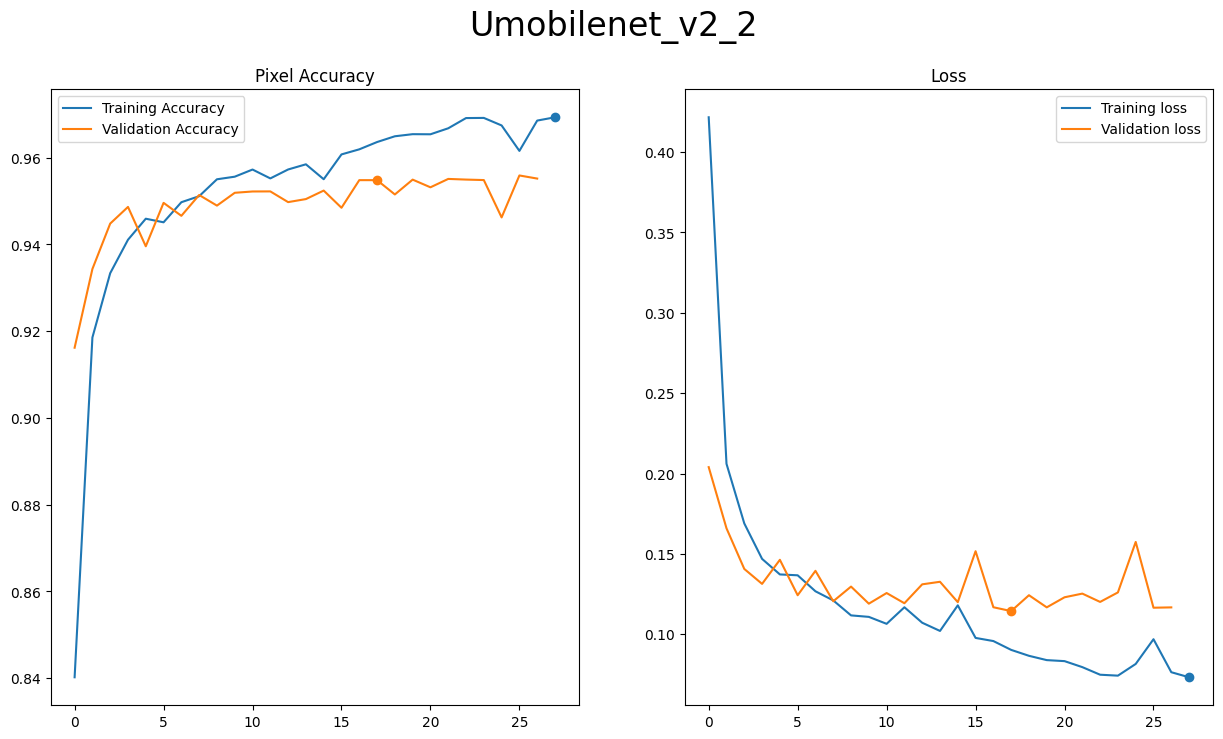

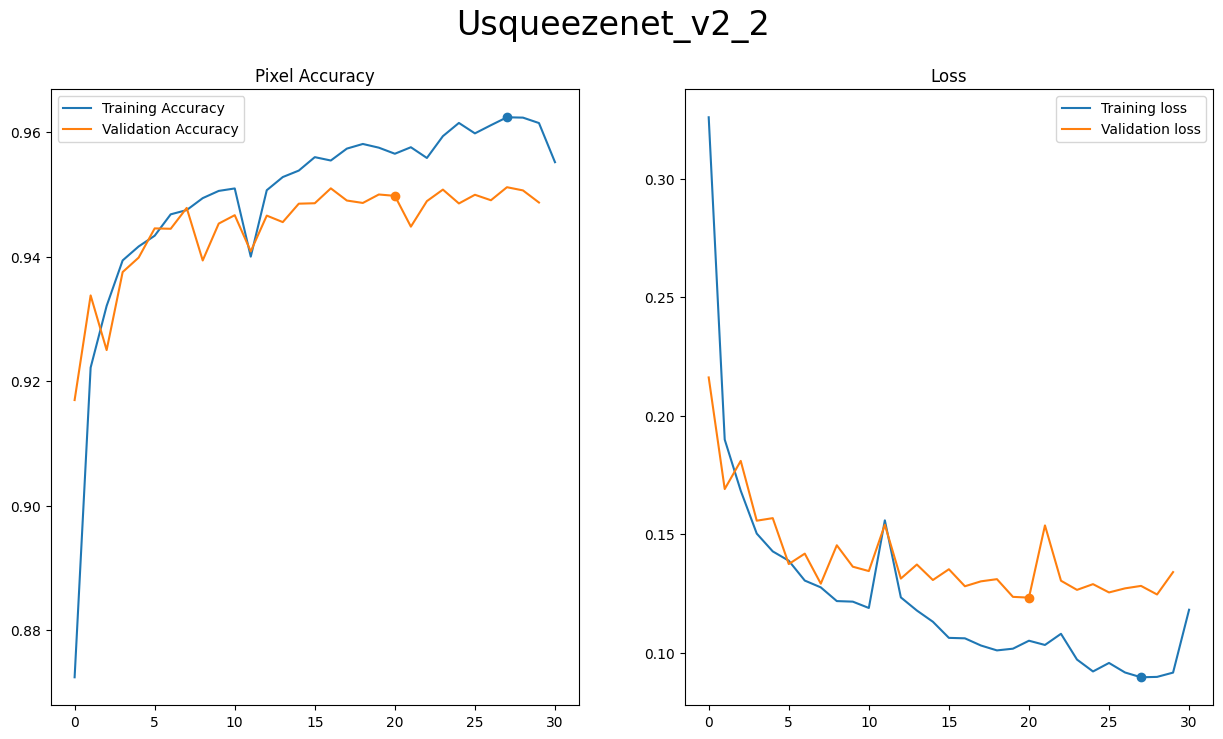

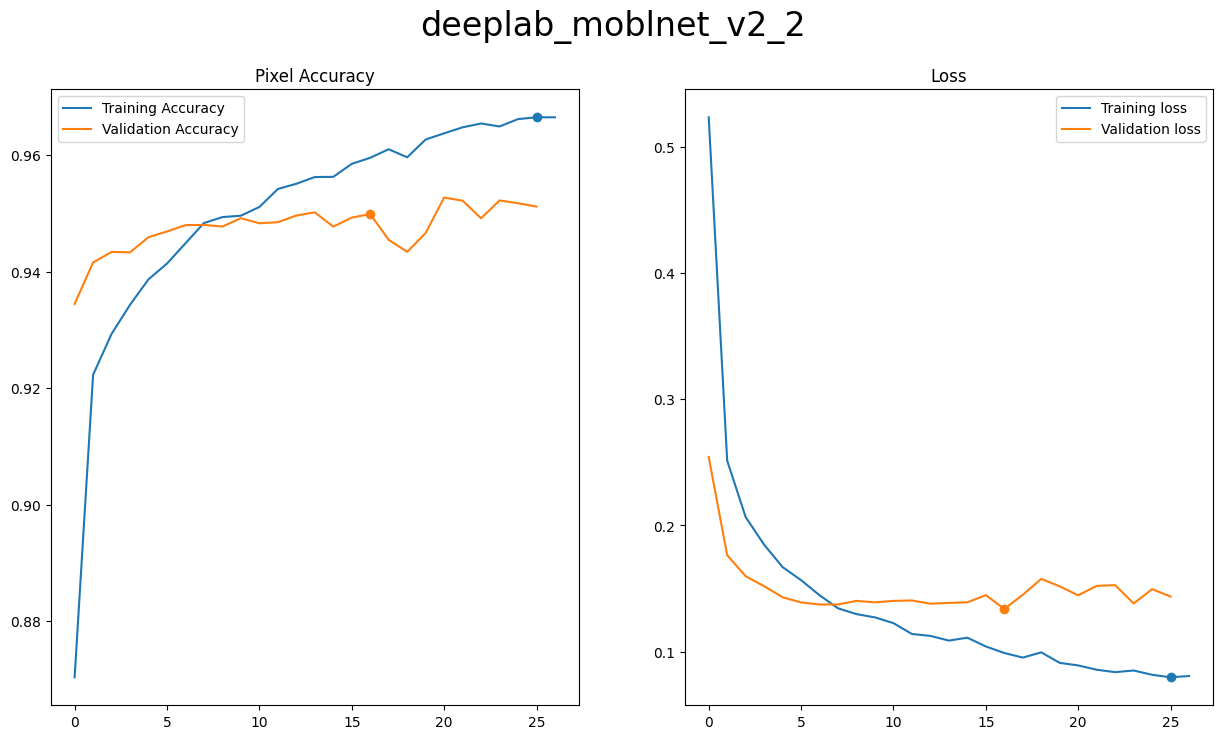

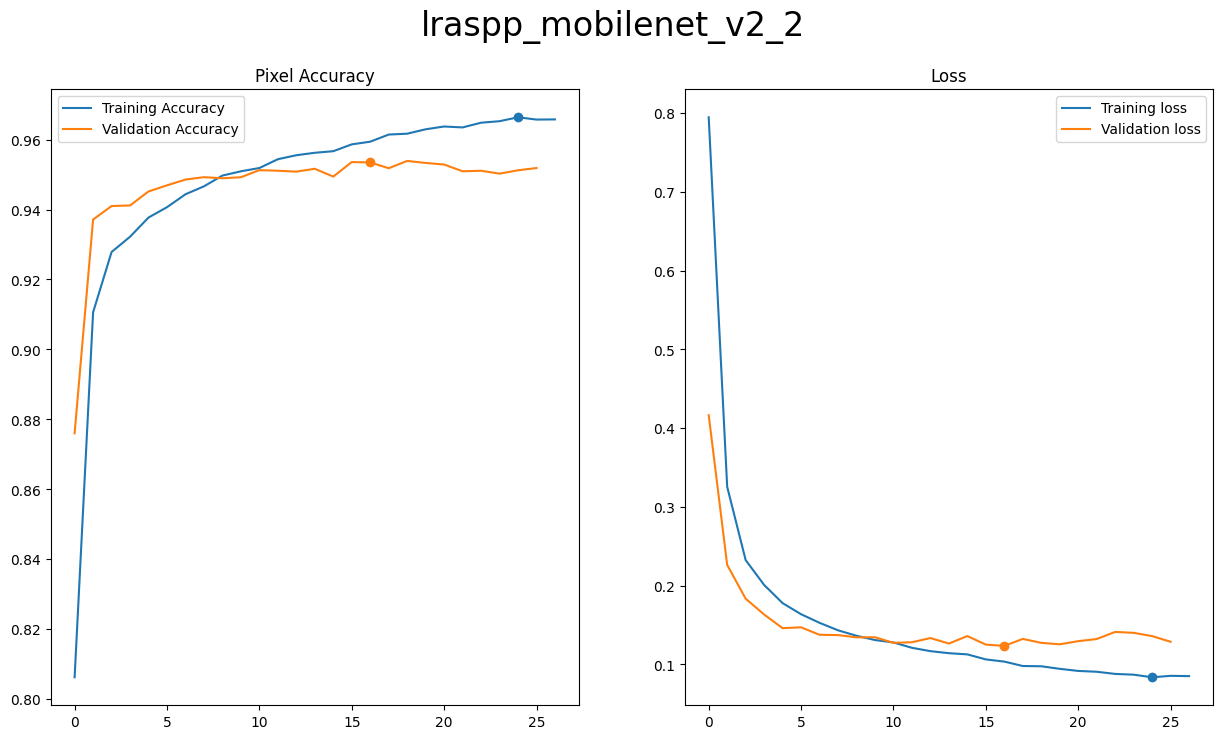

In [48]:
for name in model_names:
    Min_loss_t=np.argmin(train_loss_avg[name])
    Min_loss_v=np.argmin(val_loss_avg[name])

    plt.figure(figsize=(15, 8))
    plt.suptitle(name, fontsize=24)
    # Plot accuracy
    plt.subplot(121)
    plt.plot(train_acc_avg[name], label='Training Accuracy')
    plt.plot(val_acc_avg[name], label='Validation Accuracy')
    plt.scatter(Min_loss_t, train_acc_avg[name][Min_loss_t ])
    plt.scatter(Min_loss_v, val_acc_avg[name][Min_loss_v ])
    plt.title("Pixel Accuracy")
    plt.legend()

    # Plot the loss
    plt.subplot(122)
    plt.plot(train_loss_avg[name], label='Training loss')
    plt.plot(val_loss_avg[name], label='Validation loss')
    plt.scatter(Min_loss_t, train_loss_avg[name][Min_loss_t ])
    plt.scatter(Min_loss_v, val_loss_avg[name][Min_loss_v ])
    plt.title("Loss")
    plt.legend()
    plt.show()

#### Models comparison

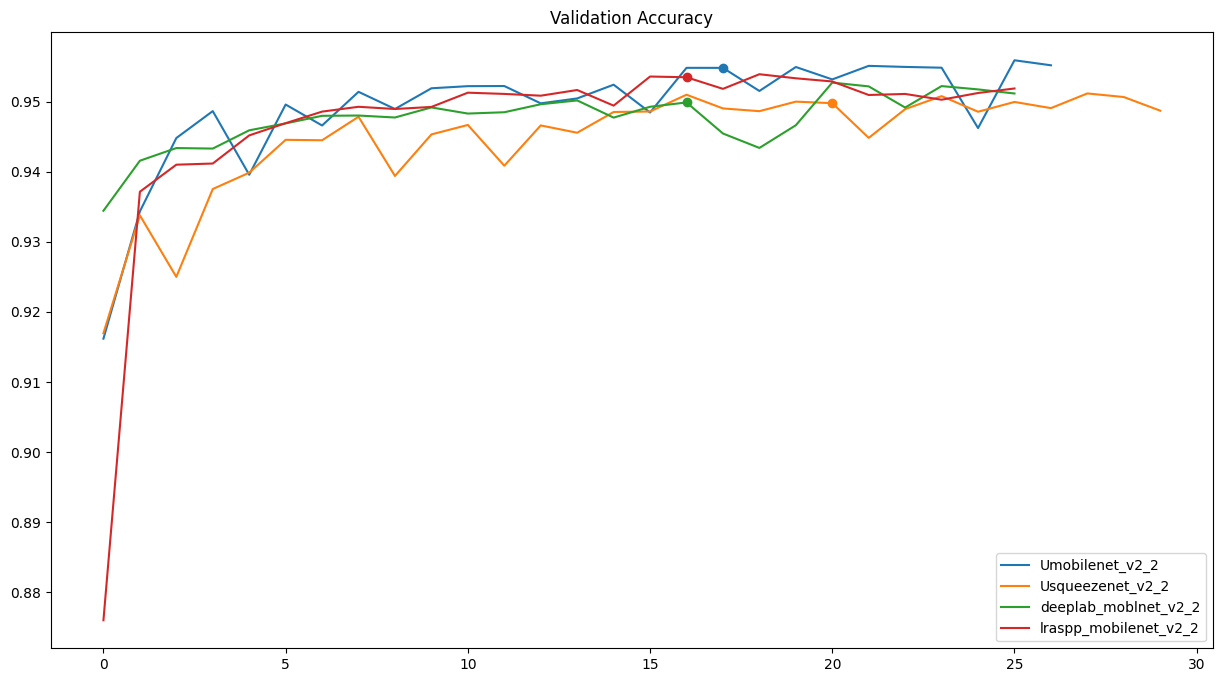

In [50]:
plt.figure(figsize=(15, 8))
for name in model_names:
    Min_loss_v=np.argmin(val_loss_avg[name])
    plt.plot(val_acc_avg[name], label=name)
    plt.scatter(Min_loss_v, val_acc_avg[name][Min_loss_v])
    plt.legend()

plt.title('Validation Accuracy')    
plt.show()

In [51]:
performance = pd.DataFrame([[round(val_acc_avg[name][np.argmin(val_loss_avg[name])],3)] for name in model_names],\
                            columns=pd.MultiIndex.from_product([['Models Performance'],['Pixel Accuracy']]),\
                                  index=pd.Index([name for name in model_names]))  
                      
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #2AFF; color: #000000; text-align: center"
}
properties = {"border": "1px solid black", "width": "75px", "text-align": "center"}

perfomance=performance.style.format(precision=4).set_table_styles([ headers]).set_properties(**properties)
perfomance

,Models Performance
,Pixel Accuracy
Umobilenet_v2_2,0.9550
Usqueezenet_v2_2,0.9500
deeplab_moblnet_v2_2,0.9500
lraspp_mobilenet_v2_2,0.9530


In [47]:
# Load models
Loaded_moblnet_model = Unet_mobilenet(n_class=n_class,
                            pretrained=False
                             ).to(device)

Loaded_moblnet_model.load_state_dict(torch.load('../models/mine/Umobilenet_v2_2.pth'))

<All keys matched successfully>

### Load weights

In [41]:
# Load models
Loaded_moblnet_model = Unet_mobilenet(n_class=n_class,
                            pretrained=False
                             ).to(device)

Loaded_moblnet_model.load_state_dict(torch.load('../models/mine/Umobilenet_v2_2.pth'))


Loaded_sqzenet_model = Unet_squeezenet(n_class=n_class,
                            pretrained=False
                             ).to(device)


Loaded_sqzenet_model.load_state_dict(torch.load('../models/mine/Usqueezenet_v2_2.pth'))


deeplab_mobl_model.load_state_dict(torch.load('../models/mine/deeplab_moblnet_v2_2.pth'))

lraspp_mobl_model.load_state_dict(torch.load('../models/mine/lraspp_mobilenet_v2_2.pth'))

<All keys matched successfully>

In [42]:
loaded_models = [Loaded_moblnet_model, Loaded_sqzenet_model, deeplab_mobl_model, lraspp_mobl_model]

#### Inference 

In [16]:
# get each patch name
tile_names = glob(os.path.join('../data/image_tiles_1164',"*.tif"))
# Number of tiles
len(tile_names)

15625

In [17]:
# Transformation for normalizing and converting the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [18]:
# Set output path
output_folder_mergedTiles = '../data/mask_merged'

In [46]:
batch_size = 32 # Batch size for inference

for i, loaded_model in enumerate(loaded_models):

    start_time = time.time()
    
    # Prediction
    loaded_model.eval()
    with torch.no_grad():
        num_images = len(tile_names)
        num_batches = int(np.ceil(num_images / batch_size))

        for batch_idx in range(num_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(batch_start + batch_size, num_images)
            batch_tile_names = tile_names[batch_start:batch_end]

            batch_images = []
            batch_mask_names = []
            for image in batch_tile_names:
                mask_name = image.split('\\')[-1]
                image_ = cv2.imread(image)
                image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
                val_im = transform(image_).to(device)
                batch_images.append(val_im)
                batch_mask_names.append(mask_name)

            batch_images = torch.stack(batch_images, dim=0)

            if i in [2,3]:
                pred_masks = loaded_model(batch_images)['out']
            else:
                pred_masks = loaded_model(batch_images)

            pred_masks = torch.argmax(pred_masks, dim=1).cpu().numpy()

            for idx, image in enumerate(batch_tile_names):
                mask_name = batch_mask_names[idx]
                pred_mask_ = pred_masks[idx]

                with rio.open(image) as tile:
                    with rio.Env():
                        profile = tile.profile
                        profile.update(
                            dtype=rio.uint8,
                            count=1,
                            compress='lzw',
                            nodata=255)

                        with rio.open(f'../data/predictions/{mask_name}', 'w', **profile) as dst:
                            dst.write(pred_mask_.astype(rio.uint8), 1)

    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60
    print(f'Inference time for {model_names[i]}: {np.floor(elapsed_time)} min {(elapsed_time-np.floor(elapsed_time))*60:.4f} secs')

    out_path = os.path.join(output_folder_mergedTiles, f'{model_names[i]}.tif')
    # Merge and save the patches
    create_image_from_patches(patches_path='../data/predictions', out_path=out_path)
    shutil.rmtree('../data/predictions')
    os.makedirs('../data/predictions', exist_ok=True)


Inference time for Umobilenet_v2_2: 30.0 min 34.3742 secs
Inference time for Usqueezenet_v2_2: 28.0 min 35.0891 secs
Inference time for deeplab_moblnet_v2_2: 27.0 min 44.0098 secs
Inference time for lraspp_mobilenet_v2_2: 27.0 min 41.4145 secs


#### Export to ONNX

In [47]:
for name, lded_model in zip(model_names, loaded_models):
    convert_2_onnx(f"../models/{name}.onnx", lded_model)

======= Diagnostic Run torch.onnx.export version 2.1.0.dev20230718+cu121 =======
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

======= Diagnostic Run torch.onnx.export version 2.1.0.dev20230718+cu121 =======
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

======= Diagnostic Run torch.onnx.export version 2.1.0.dev20230718+cu121 =======
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

======= Diagnostic Run torch.onnx.export version 2.1.0.dev20230718+cu121 =======
verbose: False, log level: 40
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#### Inference on ONNX model

In [20]:
unet_moblet_onnx = onnx.load("../models/mine/Umobilenet_v2_2.onnx")
onnx.checker.check_model(unet_moblet_onnx)

In [21]:
def to_numpy(X):
   return X.detach().cpu().numpy() if X.requires_grad else  X.cpu().numpy()

In [24]:
batch_size = 32 # Batch size for inference


ort_session = ort.InferenceSession("../models/Umobilenet_v2_2_dynamic.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = ort_session.get_inputs()[0].name
start_time = time.time()
with torch.no_grad():
    num_images = len(tile_names)
    num_batches = int(np.ceil(num_images / batch_size))

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, num_images)
        batch_tile_names = tile_names[batch_start:batch_end]

        batch_images = []
        batch_mask_names = []
        for image in batch_tile_names:
            mask_name = image.split('\\')[-1]
            image_ = cv2.imread(image)
            image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
            val_im = transform(image_).to(device)
            batch_images.append(val_im)
            batch_mask_names.append(mask_name)

        batch_images = torch.stack(batch_images, dim=0)

        pred_masks = ort_session.run(None, {input_name: to_numpy(batch_images)})
        pred_masks = torch.squeeze(torch.from_numpy(np.array(pred_masks)),0)
        pred_masks = torch.argmax(pred_masks, dim=1).cpu().numpy()

        for idx, image in enumerate(batch_tile_names):
            mask_name = batch_mask_names[idx]
            
            pred_mask_ = pred_masks[idx]

            with rio.open(image) as tile:
                with rio.Env():
                    profile = tile.profile
                    profile.update(
                        dtype=rio.uint8,
                        count=1,
                        compress='lzw',
                        nodata=255)

                    with rio.open(f'../data/predictions/{mask_name}', 'w', **profile) as dst:
                        dst.write(pred_mask_.astype(rio.uint8), 1)


end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f'Inference time for Umobilenet_v2_2_onnx: {np.floor(elapsed_time)} min {(elapsed_time-np.floor(elapsed_time))*60:.4f} secs')

start_time = time.time()
out_path = os.path.join(output_folder_mergedTiles, f'Umobilenet_v2_2_32onnx.tif')
# Merge and save the patches
create_image_from_patches(patches_path='../data/predictions', out_path=out_path)
end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f'Time for merging patches: {np.floor(elapsed_time)} min {(elapsed_time-np.floor(elapsed_time))*60:.4f} secs')

shutil.rmtree('../data/predictions')
os.makedirs('../data/predictions', exist_ok=True)


Inference time for Umobilenet_v2_2_onnx: 46.0 min 10.6360 secs
Time for merging patches: 9.0 min 6.7096 secs


### End!